# Create multi class dataset

In [28]:
#import
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

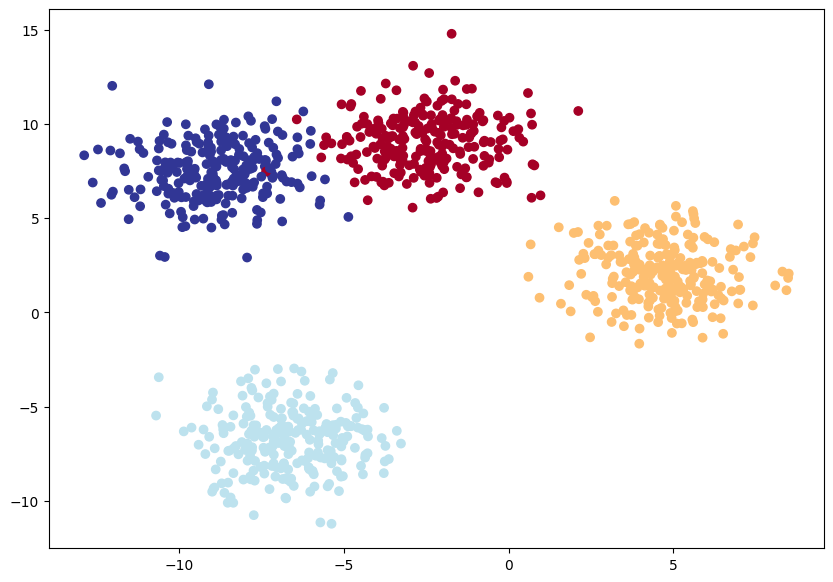

In [29]:
# create hyperparameter
NUM_CLASSES=4
NUM_FEATURES=2
RANDOM_SEED=42

X_blob,y_blob=make_blobs(n_samples=1000,n_features=NUM_FEATURES,centers=NUM_CLASSES,cluster_std=1.5,random_state=RANDOM_SEED)

#turn data to tensor
X_blob=torch.from_numpy(X_blob).type(torch.float)
y_blob=torch.from_numpy(y_blob).type(torch.LongTensor)

#split data
X_blob_train,X_blob_test,y_blob_train,y_blob_test=train_test_split(X_blob,y_blob,test_size=0.2,random_state=RANDOM_SEED)

#visualize
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0],X_blob[:,1],c=y_blob,cmap=plt.cm.RdYlBu);

# Build model

In [30]:
# create device agnostic code
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [31]:
#import
import torch
from torch import nn

#build model
class BlobModel(nn.Module):
  def __init__(self,input_features,output_features,hidden_units=8):
    super().__init__()

    self.linear_layer_stack=nn.Sequential(
        nn.Linear(in_features=input_features,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=output_features)
    )
  def forward(self,x):
    return self.linear_layer_stack(x)

#create an instance of BlobModel
model_4=BlobModel(input_features=2,output_features=4,hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [32]:
# loss function & optimizer
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=model_4.parameters(),lr=0.1)
# accuracy
def accuracy_fn(y_true,y_pred):
  correct=torch.eq(y_true,y_pred).sum().item()
  acc=(correct/len(y_pred))*100
  return acc

In [33]:
# train & test loop
torch.manual_seed(42)

X_blob_train,y_blob_train=X_blob_train.to(device), y_blob_train.to(device)
X_blob_test,y_blob_test=X_blob_test.to(device),y_blob_test.to(device)

epochs=1000

for epoch in range(epochs):
  model_4.train()

  y_logits=model_4(X_blob_train)
  y_pred=torch.softmax(y_logits,dim=1).argmax(dim=1)

  loss=loss_fn(y_logits,y_blob_train)
  acc=accuracy_fn(y_true=y_blob_train,y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  #testing
  model_4.eval()
  with torch.inference_mode():
    test_logits=model_4(X_blob_test)
    test_preds=torch.softmax(test_logits,dim=1).argmax(dim=1)
    test_loss=loss_fn(test_logits,y_blob_test)
    test_acc=accuracy_fn(y_true=y_blob_test,y_pred=test_preds)
  #print
  if epoch%100==0:
    print(f"Epoch:{epoch}|Loss:{loss:.4f},Acc:{acc:.2f}%|Test loss:{test_loss:.4f}, Test acc:{test_acc:.2f}%")

Epoch:0|Loss:1.1588,Acc:40.38%|Test loss:1.0755, Test acc:48.00%
Epoch:100|Loss:0.0331,Acc:99.25%|Test loss:0.0243, Test acc:99.50%
Epoch:200|Loss:0.0266,Acc:99.25%|Test loss:0.0165, Test acc:99.50%
Epoch:300|Loss:0.0250,Acc:99.25%|Test loss:0.0144, Test acc:99.50%
Epoch:400|Loss:0.0243,Acc:99.25%|Test loss:0.0134, Test acc:99.50%
Epoch:500|Loss:0.0238,Acc:99.25%|Test loss:0.0127, Test acc:99.50%
Epoch:600|Loss:0.0234,Acc:99.25%|Test loss:0.0122, Test acc:99.50%
Epoch:700|Loss:0.0231,Acc:99.25%|Test loss:0.0118, Test acc:99.50%
Epoch:800|Loss:0.0228,Acc:99.25%|Test loss:0.0115, Test acc:99.50%
Epoch:900|Loss:0.0225,Acc:99.25%|Test loss:0.0112, Test acc:99.50%


In [34]:
# making & evaluating predictions
model_4.eval()
with torch.inference_mode():
  y_logits=model_4(X_blob_test)
y_logits[:10]

tensor([[ -2.3751,  10.9387, -10.2038, -11.3271],
        [ -2.1934,  -9.4839,  -6.3062,   5.2289],
        [ -4.9855,  -5.3790,   5.3840,  -4.3115],
        [ -3.0428,   8.1532,  -5.4971,  -6.6867],
        [  6.4903,  -2.8975, -12.3324,  -8.4675],
        [ -2.7723, -11.1927,  -7.4741,   6.3901],
        [ -4.3608,  -4.5814,   4.6891,  -3.5910],
        [  5.8017,  -6.8308,  -9.7351,  -4.1265],
        [ -6.3789,  -6.9228,   6.6639,  -5.5251],
        [  6.2822,  -5.5357, -10.3558,  -5.4748]])

In [35]:
y_pred_probs=torch.softmax(y_logits,dim=1)
y_pred_probs[:10]

tensor([[1.6515e-06, 1.0000e+00, 6.5754e-10, 2.1385e-10],
        [5.9742e-04, 4.0741e-07, 9.7747e-06, 9.9939e-01],
        [3.1371e-05, 2.1165e-05, 9.9989e-01, 6.1552e-05],
        [1.3729e-05, 9.9998e-01, 1.1796e-06, 3.5901e-07],
        [9.9992e-01, 8.3726e-05, 6.6887e-09, 3.1906e-07],
        [1.0490e-04, 2.3112e-08, 9.5245e-07, 9.9989e-01],
        [1.1735e-04, 9.4120e-05, 9.9954e-01, 2.5340e-04],
        [9.9995e-01, 3.2638e-06, 1.7882e-07, 4.8777e-05],
        [2.1657e-06, 1.2571e-06, 9.9999e-01, 5.0863e-06],
        [9.9998e-01, 7.3709e-06, 5.9454e-08, 7.8339e-06]])

In [36]:
y_preds=torch.argmax(y_pred_probs,dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [37]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [38]:
# import pre-built plot function
import requests
from pathlib import Path

if Path('helper_fucntions.py').is_file():
  print('Skip')
else:
  request=requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
  with open ('helper_functions.py','wb')as f:
    f.write(request.content)
from helper_functions import plot_predictions,plot_decision_boundary

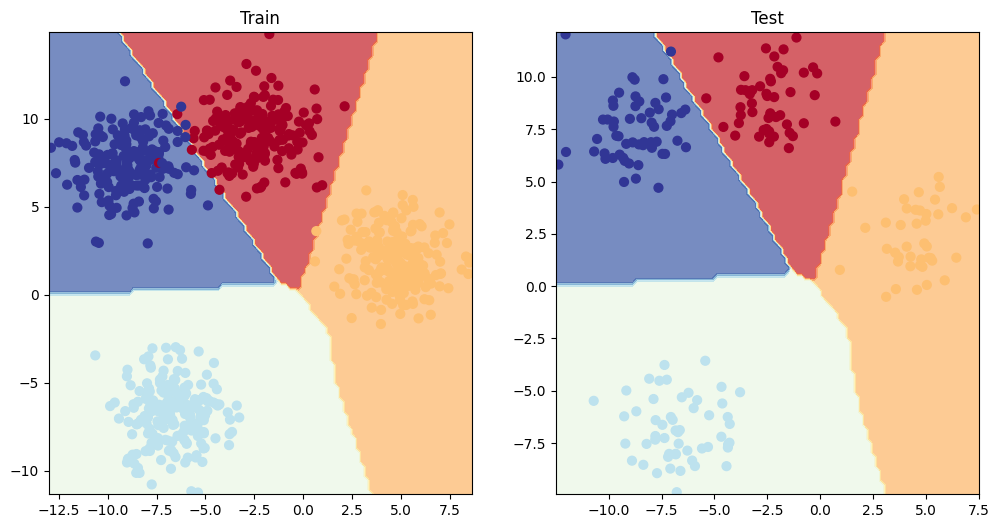

In [39]:
#visual
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_4,X_blob_train,y_blob_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_4,X_blob_test,y_blob_test)

## a few more classification metrics ( to evaluate model)

In [40]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 9.2 MB/s eta 0:00:00


In [43]:
from torchmetrics import Accuracy
torchmetric_accuracy=Accuracy(task="multiclass", num_classes=4)
torchmetric_accuracy(y_preds,y_blob_test)

tensor(0.9950)

In [ ]:
;